# DEA Coastlines validation

To do:
* [X] Change output CRS to Australian Albers
* [X] Discard validation sides with multiple intersects?
* [X] Split analysis code into:
    * Aggregate multiple profiles and export into single file
    * Analyse and plot single file
* [X] Add extraction of environmental data for each profile line

In [ ]:
# fnames = glob.glob('input_data/nswbpd/*.csv')
# out = []

# for fname in fnames:
#     print(fname)
#     df = pd.read_csv(fname, skiprows=5)
#     out.append(df.Elevation < 0)
# #     out.append(df.groupby(['Beach', 'Block', 'Profile', 'Year/Date'])['Elevation'].min() < 0)


## Load modules/functions


In [37]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import box
import multiprocessing as mp
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

sys.path.append('/g/data/r78/DEACoastlines/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df,
              fname='test.shp',
              x='x',
              y='y',
              crs='EPSG:3577',
              output_crs='EPSG:3577'):
    
    # Convert datetimes to strings
    df = df.copy()
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gdf = gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_crs(output_crs).to_file(fname)
    
    return gdf


def export_eval(df, output_name, output_crs='EPSG:3577'):
    
    from shapely.geometry import box, Point, LineString

    # Extract geometries
    val_points = gpd.points_from_xy(x=df.val_x, y=df.val_y)
    deacl_points = gpd.points_from_xy(x=df.deacl_x, y=df.deacl_y)
    df_profiles = df.groupby('id').first()
    profile_lines = df_profiles.apply(
        lambda x: LineString([(x.start_x, x.start_y), (x.end_x, x.end_y)]), axis=1)

    # Export validation points
    val_gdf = gpd.GeoDataFrame(data=df,
                               geometry=val_points,
                               crs=output_crs).to_crs('EPSG:4326')
    val_gdf.to_file(f'figures/eval/{output_name}_val.geojson', 
                    driver='GeoJSON')

    # Export DEACL points
    deacl_gdf = gpd.GeoDataFrame(data=df,
                                 geometry=deacl_points,
                                 crs=output_crs).to_crs('EPSG:4326')
    deacl_gdf.to_file(f'figures/eval/{output_name}_deacl.geojson', 
                      driver='GeoJSON')

    # Export profiles
    profile_gdf = gpd.GeoDataFrame(data=df_profiles,
                                 geometry=profile_lines,
                                 crs=output_crs).to_crs('EPSG:4326')
    profile_gdf.to_file(f'figures/eval/{output_name}_profiles.geojson', 
                        driver='GeoJSON')


def deacl_val_stats(val_dist, deacl_dist, n=None, remove_bias=False):

    np.seterr(all='ignore')

    # Compute difference and bias
    diff_dist = val_dist - deacl_dist
    bias = diff_dist.mean()
    
    if remove_bias:
        deacl_dist += bias
        diff_dist = val_dist - deacl_dist

    # Compute stats
    if n is None:
        n = len(val_dist)
    else:
        n = sum(n)
        
    mae = mean_absolute_error(val_dist, deacl_dist)
    rmse = mean_squared_error(val_dist, deacl_dist)**0.5
    
    
    if n > 1:
        corr = np.corrcoef(x=val_dist, y=deacl_dist)[0][1]
        stdev = diff_dist.std()
    else:
        corr = np.nan
        stdev = np.nan

    return pd.Series({
        'n': n,
        'mae': f'{mae:.2f}',
        'rmse': f'{rmse:.2f}',
        'stdev': f'{stdev:.2f}',
        'corr': f'{corr:.3f}',
        'bias': f'{bias:.2f}',
    }).astype(float)


def rse_tableformat(not_bias_corrected, bias_corrected, groupby='source'):

    # Fix rounding and total observations
    not_bias_corrected['n'] = not_bias_corrected['n'].astype(int)
    not_bias_corrected[['bias', 'stdev', 'mae', 'rmse']] = not_bias_corrected[['bias', 'stdev', 'mae', 'rmse']].round(1)
    not_bias_corrected['n'] = not_bias_corrected.groupby(groupby)['n'].sum()
    
    # Move bias corrected values into brackets
    not_bias_corrected['MAE (m)'] = (not_bias_corrected.mae.astype('str') + ' (' + 
                                 bias_corrected.mae.round(1).astype('str') + ')')
    not_bias_corrected['RMSE (m)'] = (not_bias_corrected.rmse.astype('str') + ' (' + 
                                  bias_corrected.rmse.round(1).astype('str') + ')')
    
    # Sort by MAE, rename columns
    not_bias_corrected = (not_bias_corrected.sort_values('mae')
     .drop(['mae', 'rmse'], axis=1)
     .rename({'stdev': 'SD (m)', 'corr': 'Correlation', 'bias': 'Bias (m)'}, axis=1)
             [['n', 'Bias (m)', 'MAE (m)', 'RMSE (m)', 'SD (m)', 'Correlation']])

    return not_bias_corrected


rename_dict = {
    'Beachrock undiff': 'rocky',
    'Beachrock undiff dominant': 'rocky',
    'Boulder or shingle-grade beach undiff': 'rocky',
    'Boulder groyne or breakwater undiff': 'rocky',
    'Flat boulder deposit (rock) undiff': 'rocky',
    'Hard bedrock shore': 'rocky',
    'Hard bedrock shore inferred': 'rocky',
    'Hard rock cliff (>5m)': 'rocky',
    'Hard rocky shore platform': 'rocky',
    'Rocky shore platform (undiff)': 'rocky',
    'Sloping boulder deposit (rock) undiff': 'rocky',
    'Sloping hard rock shore': 'rocky',
    'Sloping soft `bedrock¿ shore': 'rocky',
    'Sloping soft \u2018bedrock\u2019 shore': 'rocky',
    'Soft `bedrock¿ shore inferred': 'rocky',
    'Soft `bedrock¿ shore platform': 'rocky',
    'Beach (sediment type undiff)': 'sandy',
    'Fine-medium sand beach': 'sandy',
    'Fine-medium sandy tidal flats': 'sandy',
    'Mixed sand and shell beach': 'sandy',
    'Mixed sandy shore undiff': 'sandy',
    'Perched sandy beach (undiff)': 'sandy',
    'Sandy beach undiff': 'sandy',
    'Sandy beach with cobbles/pebbles (rock)': 'sandy',
    'Sandy shore undiff': 'sandy',
    'Sandy tidal flats': 'sandy',
    'Sandy tidal flats with coarse stony debris': 'sandy',
    'Sandy tidal flats, no bedrock protruding': 'sandy',
    'Sloping coffee rock deposit': 'rocky',
    'Muddy tidal flats': 'muddy',
    'Tidal flats (sediment undiff)': 'muddy',
    'Artificial shoreline undiff': 'rocky',
    'Artificial boulder structures undiff': 'rocky',
    'Boulder revetment': 'rocky',
    'Boulder seawall': 'rocky',
    'Concrete sea wall': 'rocky',
    'Piles (Jetty)': 'rocky',
    'Coarse sand beach': 'sandy'
}


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# to_vector(output_stats, fname='test6.shp', x='0_x', y='0_y', crs='EPSG:3577')

## Pre-processing


### Sunshine Coast

In [ ]:
sites = ['8.Pumicestone - Bribie', '1.Coolum-Sunshine', '5.Dicky Beach', 
        '7.Kings Beach', '3.Mooloolaba', '2.Mudjimba-Yaroomba', '6.Shelly Beach',
        '4.South Mooloolaba']

for site in sites:
    deacl_val.preprocess_sunshinecoast(site, datum=0, overwrite=True)


### Moruya

In [ ]:
deacl_val.preprocess_moruya(fname_out='output_data/moruya.csv', datum=0, overwrite=True)

### Victoria/Deakin
* [X] Renovated

In [ ]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

### WRL Narrabeen 
* [X] Renovated

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2019.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    for fname in glob.glob('input_data/nswbpd/*.csv'):
        pool.apply_async(deacl_val.preprocess_nswbpd, 
                         [fname, 0, False])

    pool.close()
    pool.join()
    
# fname = '/g/data/r78/DEACoastlines/validation/input_data/nswbpd/photogrammetry_Xsections_Lennox Head.csv'
# profiles_df, intercept_df = deacl_val.preprocess_nswbpd(fname, 0, True)


### City of Gold Coast
* [X] Renovated
* [ ] Fix North Kirra name

In [ ]:
sites = ['BILINGA', 'BROADBEACH', 'BURLEIGH HEADS', 'COOLANGATTA', 'CURRUMBIN',
         'DURANABH', 'FINGAL', 'GREENMOUNT HILL', 'KINGSCLIFF', 'KIRRA',
         'MAIN BEACH', 'MERMAID BEACH', 'MIAMI', 'Main Beach Cross Sections',
         'NARROWNECK', 'NO*TlH KIRRA', 'PALM BEACH', 'POINT DANGER', 
         'RAINBOW BAY', 'SEAWAY CENTRE LINE', 'SNAPPER ROCKS', 
         'SOUTH STRADBROKE', 'SURFERS PARADISE', 'THE SPIT', 'TUGUN', 
         'TWEED RIVER ENTRANCE']
# sites=['MAIN BEACH']

with mp.Pool(mp.cpu_count()) as pool:
    for site in sites:
        pool.apply_async(deacl_val.preprocess_cgc, 
                         [site, 0, False])

    pool.close()
    pool.join()


### TASMARC
* [X] Renovated

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]
# sites = sites[2:]

with mp.Pool(mp.cpu_count()) as pool:
    for site in sites:
        pool.apply_async(deacl_val.preprocess_tasmarc, 
                         [site, 0, False])

    pool.close()
    pool.join()


### WA DoT
* [X] Renovated

In [ ]:
regions_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577').iloc[::-1]
regions_gdf.index = (regions_gdf.LABEL
                     .str.replace(' - ', '_')
                     .str.replace('-', '')
                     .str.replace(' ', '')
                     .str.replace('/', '')
                     .str.replace(',', '')
                     .str.replace('_', '-')
                     .str.lower())
regions_gdf.head(1)


In [ ]:
deacl_val.coastal_transects_parallel(
    regions_gdf,
    interval=200,
    transect_length=500,
    simplify_length=200,
    transect_buffer=50,
    overwrite=False,
    output_path='input_data/coastal_transects_wadot.geojson')

In [ ]:
with mp.Pool(mp.cpu_count()-1) as pool:
    for i, _ in regions_gdf.iterrows():
        pool.apply_async(deacl_val.preprocess_wadot, 
                         [regions_gdf.loc[[i]], False])

    pool.close()
    pool.join()


## DaSilva 2021

In [ ]:
# fname='input_data/dasilva2021/dasilva_etal_2021_shorelines.shp'
# val_gdf = gpd.read_file(fname).to_crs('EPSG:3577')
# val_gdf = val_gdf.loc[val_gdf.Year_ > 1987]
# val_gdf['Year_'] = val_gdf.Year_.astype(str)
# val_gdf = val_gdf.set_index('Year_')


# # transect_gdf = gpd.read_file('input_data/dasilva2021/dasilva_etal_2021_retransects.shp').to_crs('EPSG:3577')[['id', 'order', 'geometry']]
# transect_gdf.columns = ['profile', 'order', 'geometry']



# ransect_gdf['profile'] = transect_gdf.profile.astype(str)
#     transect_gdf = gpd.clip(gdf=transect_gdf, mask=compartment, keep_geom_type=True)



In [ ]:
deacl_val.preprocess_dasilva2021()

In [ ]:
from shapely.geometry import box, Point, LineString

# Add measurement metadata
intersect_gdf[['start_x', 'start_y']] = intersect_gdf.apply(
    lambda x: pd.Series(x.geometry.coords[0]), axis=1)
intersect_gdf[['end_x', 'end_y']] = intersect_gdf.apply(
    lambda x: pd.Series(x.geometry.coords[1]), axis=1)
intersect_gdf['0_dist'] = intersect_gdf.apply(
    lambda x: Point(x.start_x, x.start_y).distance(x['val_point']), axis=1)
intersect_gdf[['0_x', '0_y']] = intersect_gdf.apply(
    lambda x: pd.Series(x.val_point.coords[0][0:2]), axis=1)

### WA DoT - Stirling

In [ ]:
deacl_val.preprocess_stirling(fname_out='output_data/stirling_stirling.csv',
                              datum=0)

### SA Department of Environment and Water

In [ ]:
sites = ['200048',
 '320010',
 '320011',
 '330005',
 '330014',
 '425001',
 '425002',
 '440004',
 '525019',
 '525022',
 '525023',
 '530009',
 '545001',
 '555007',
 '555012',
 '815013']

fname = f'input_data/sadew/{sites[15]}.CSV'
print(fname)
profile_df = deacl_val.preprocess_sadew(fname, datum=0, overwrite=True)
profile_df.head(2)

In [ ]:
# from pathlib import Path
# for fname in fname_list:
#     preprocess_sadew(fname, datum=0, overwrite=False)

fname_list = glob.glob('input_data/sadew/*.CSV')    

with mp.Pool(mp.cpu_count()-1) as pool:
    for fname in fname_list:
        pool.apply_async(deacl_val.preprocess_sadew, 
                         [fname, 0, True])

    pool.close()
    pool.join()


### Fellowes et al. 20221

In [ ]:
import math
import glob
import re
import os.path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pathlib import Path
from io import StringIO
from pyproj import Transformer
from itertools import takewhile
from scipy import stats
import multiprocessing as mp
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from shapely.geometry import box, Point, LineString
pd.read_excel('input_data/fellowes2021/Fellowes_et_al_2021_SUPP_Estuarine_Beach_Shorelines_V2.xlsx', sheet_name=0, header=1).head()

In [ ]:
coords = pd.read_excel('input_data/fellowes2021/Fellowes_et_al_2021_SUPP_Estuarine_Beach_Shorelines_V2.xlsx',
                       sheet_name='Profile Locations',
                       header=1,
                       names=['estuary', 'beach', 'profile', 'start_y', 'start_x', 'end_y', 'end_x' ]).drop('estuary', axis=1)
coords['beach'] = coords.beach.str.replace(" ", "").str.replace("(", "").str.replace(")", "").str.replace('Fishermans','Frenchmans').str.lower()
coords['section'] = 'all'
coords['name'] = 'fellowes2021'
coords['source'] = 'aerial photogrammetry'
coords['slope'] = np.nan
coords['id'] = (coords.beach + '_' + coords.section + '_' + coords.profile)

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs('EPSG:4326', 'EPSG:3577', always_xy=True)
coords['start_x'], coords['start_y'] = trans.transform(coords.start_x.values,
                                                       coords.start_y.values)
coords['end_x'], coords['end_y'] = trans.transform(coords.end_x.values,
                                                   coords.end_y.values)
coords

In [ ]:
fellowes_data = pd.read_excel('input_data/fellowes2021/Fellowes_et_al_2021_SUPP_Estuarine_Beach_Shorelines_V2.xlsx', None)
beach_list = list(fellowes_data.keys())[1:]

for name in beach_list:

    beach = name.split(' - ')[1].replace(" ", "").replace("(", "").replace(")", "").lower()
    fname_out = f'output_data/fellowes2021_{beach}.csv'
    print(f'Processing {beach:<80}', end='\r')

    # Load data and convert to long format
    wide_df = fellowes_data[name]
    profiles_df = pd.melt(wide_df, 
                          id_vars='Date', 
                          var_name='profile', 
                          value_name='0_dist').rename({'Date': 'date'}, axis=1)
    profiles_df['date'] = pd.to_datetime(profiles_df.date, yearfirst=True)
    profiles_df['id'] = (f'{beach}_all_' + profiles_df.profile)

    # Remove negative distances
    profiles_df = profiles_df.loc[profiles_df['0_dist'] >= 0]

    # Restrict to post 1987
    profiles_df = profiles_df[(profiles_df.date.dt.year > 1987)]

    # Merge profile coordinate data into transect data
    profiles_df = profiles_df.merge(coords, on=['id', 'profile'])

    # Add coordinates at supplied distance along transects
    profiles_df[['0_x', '0_y']] = profiles_df.apply(
        lambda x: pd.Series(deacl_val.dist_along_transect(x['0_dist'], 
                                                x.start_x, 
                                                x.start_y,
                                                x.end_x,
                                                x.end_y)), axis=1)

    # Keep required columns
    shoreline_df = profiles_df[['id', 'date', 'beach', 
                                'section', 'profile', 'name',
                                'source', 'slope', 'start_x', 
                                'start_y', 'end_x', 'end_y', 
                                '0_dist', '0_x', '0_y']]

    shoreline_df.to_csv(fname_out, index=False)


## Analysis
To investigate:
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [ ] Outliers at Shellharbour Little Lake
* [ ] **Several remaining outliers at Swansea Belmont**
* [ ] **Major issues with Valla Beach**

In [31]:
import random 
val_paths = glob.glob('output_data/*.csv')
random.shuffle(val_paths)
deacl_path = '/g/data/r78/DEACoastlines/releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_annualcoastlines_v1.0.0.shp'

prefix='v1.1.4'

# # Parallelised
# with mp.Pool(6) as pool:
#     for val_path in val_paths:
        
#         # Run analysis and close resulting figure
#         pool.apply_async(deacl_val.deacl_validation, 
#                          [val_path, deacl_path, 0, prefix, True])

#     pool.close()
#     pool.join()
    
# # Non-parallel
# for val_path in val_paths:
#     try:
#         deacl_val.deacl_validation(val_path, deacl_path, 0, prefix, False)
#     except:
#         pass

In [44]:
# Load all results into a single file
print('Combining data')
stats_list = glob.glob(f'{prefix}_*.csv')
stats_df = pd.concat([pd.read_csv(csv) for csv in stats_list])  #.query("beach == 'narrabeen'") #.query("n >= 25")

# Rename smartline categories to smaller subset
stats_df['smartline'] = stats_df.smartline.replace(rename_dict)

# Export to file
# stats_df.to_csv('deacl_all_results.csv', index=False)

# Run stats
deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist, n=stats_df.n, remove_bias=False)

Combining data


n        57668.000
mae         13.790
rmse        19.310
stdev       16.810
corr         0.991
bias         9.520
dtype: float64

In [214]:
# Export evaluation vector
output_name = prefix
export_eval(stats_df.set_index('id').loc[slope_df.index.unique()], output_name)

#### Results by substrate

##### Greater than Landsat frequency

In [45]:
# Stats by substrate, no bias correction
by_smartline = stats_df.query("n >= 22").groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_smartline_nobias = stats_df.query("n >= 22").groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

out = rse_tableformat(by_smartline, by_smartline_nobias, 'smartline')
out


,n,Bias (m),MAE (m),RMSE (m),SD (m),Correlation
smartline,,,,,,
sandy,1177,5.6,7.3 (6.1),10.3 (8.7),8.8,0.957


##### Less than Landsat frequency

In [46]:
# Stats by substrate, no bias correction
by_smartline = stats_df.query("n < 22").groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_smartline_nobias = stats_df.query("n < 22").groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

out = rse_tableformat(by_smartline, by_smartline_nobias, 'smartline')
out

,n,Bias (m),MAE (m),RMSE (m),SD (m),Correlation
smartline,,,,,,
rocky,2642,-0.1,10.7 (10.7),16.6 (16.6),16.6,0.997
sandy,52156,10.4,13.9 (11.4),19.3 (16.2),16.2,0.991
muddy,1247,0.2,16.5 (16.5),24.3 (24.2),24.3,0.962


#### Validation by rate of change

In [86]:
long_temporal = stats_df.groupby(['id']).filter(lambda x: len(x) >= 10).set_index('id')
# test = stats_df.groupby(['id']).filter(lambda x: (np.ptp(x.year) > 25) & (len(x) >= 5)).set_index('id')

# Compute rates of change for both validation and DEAC data
deacl_rates = long_temporal.groupby(['id']).apply(lambda x: deacl_stats.change_regress(
    y_vals=x.deacl_dist, x_vals=x.year, x_labels=x.year))
val_rates = long_temporal.groupby(['id']).apply(lambda x: deacl_stats.change_regress(
    y_vals=x.val_dist, x_vals=x.year, x_labels=x.year))

# Combine rates of change
slope_df = pd.merge(val_rates, 
                    deacl_rates, 
                    left_index=True, 
                    right_index=True, 
                    suffixes=('_val', '_deacl'))

deacl_val_stats(val_dist=slope_df.slope_val, deacl_dist=slope_df.slope_deacl)


n        330.000
mae        0.350
rmse       0.600
stdev      0.590
corr       0.947
bias       0.080
dtype: float64

In [87]:
deacl_val_stats(val_dist=slope_df.slope_val, deacl_dist=slope_df.slope_deacl, remove_bias=True)

n        330.000
mae        0.340
rmse       0.590
stdev      0.590
corr       0.947
bias       0.080
dtype: float64

In [72]:
slope_df_sig = slope_df.loc[(slope_df.pvalue_deacl <= 0.01) | (slope_df.pvalue_val <= 0.01)]
deacl_val_stats(val_dist=slope_df_sig.slope_val, deacl_dist=slope_df_sig.slope_deacl)

n        144.000
mae        0.310
rmse       0.520
stdev      0.520
corr       0.977
bias       0.080
dtype: float64

In [88]:
deacl_val_stats(val_dist=slope_df_sig.slope_val, deacl_dist=slope_df_sig.slope_deacl, remove_bias=True)

n        144.000
mae        0.300
rmse       0.520
stdev      0.520
corr       0.977
bias       0.080
dtype: float64

In [79]:
stats_df.set_index('id').loc[slope_df.index].n.sum()

11632

In [81]:
stats_df.set_index('id').loc[slope_df_sig.index].n.sum()

3479

In [ ]:
# # Load all results into a single file
# print('Combining data')
# stats_list = glob.glob(f'{prefix}_*.csv')
# stats_df = pd.concat([pd.read_csv(csv) for csv in stats_list])
# # stats_df.to_csv('deacl_all_results.csv', index=False)

# deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist, n=stats_df.n, remove_bias=True)

In [ ]:
# deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist, n=stats_df.n, remove_bias=True)

In [ ]:
# test = stats_df.loc[stats_df.id == 'ladyrobinsons_all_G6']
# test.plot(x='year', y='deacl_dist')
# test.plot(x='year', y='val_dist', ax=plt.gca())

In [82]:
# slope_df.index.unique()

In [83]:
# stats_df.set_index('id').loc[slope_df.index.unique()]

### Plot and analyse results

In [ ]:
# Read in results
stats_df = pd.read_csv('deacl_all_results.csv')
stats_df.head()

In [ ]:
len(stats_df.smartline.unique())

#### Validation dataset stats

Plot of validation sites:

In [ ]:
by_source = stats_df.groupby('name').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_source_nobias = stats_df.groupby('name').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

rse_tableformat(by_source, by_source_nobias, 'name')


In [ ]:
stats_gdf = gpd.GeoDataFrame(data=stats_df,
                             geometry=gpd.points_from_xy(
                                 x=stats_df.lon,
                                 y=stats_df.lat,
                                 crs='EPSG:4326')).to_crs('EPSG:3577')

stats_gdf.to_file('../bishoptaylor_2020/Validation_extent/validation_points.shp')

# Load and reverse buffer Australian boundary
aus_inside = (gpd.read_file('/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')
 .query("FEAT_CODE=='mainland'")
 .to_crs('EPSG:3577')
 .assign(dissolve=1)
 .dissolve('dissolve')
 .simplify(10000)
 .buffer(-100000)
 .buffer(50000))

# Compute convex hulls for each validation dataset
convex_hulls = stats_gdf.dissolve('name').convex_hull.buffer(50000)

# Clip convex hulls by Australia coastline
gpd.overlay(gpd.GeoDataFrame(geometry=convex_hulls), 
            gpd.GeoDataFrame(geometry=aus_inside), 
            how='difference').buffer(100000).to_file('../bishoptaylor_2020/Validation_extent/validation_extent.shp')

Number of validation sites by source:

In [ ]:
stats_df['n'].sum()

In [ ]:
stats_df.groupby("name")['n'].sum()

In [ ]:
stats_df.groupby("name")['year'].agg([np.min,np.max])

In [ ]:
rename_dict = dict(zip(stats_df.groupby(["source"])['year'].count().sort_values().index[0:4], ['Other']*4))
rename_dict = {**rename_dict, **{'aerial photogrammetry': 'Aerial photogrammetry',
                                 'drone photogrammetry': 'Drone photogrammetry',
                                 'hydrographic survey': 'Hydrographic survey',
                                 'lidar': 'LiDAR'}}

counts_per_year = (stats_df
                   .pipe(lambda x: x.assign(source_updated = x.source.replace(rename_dict)))
                   .groupby(["year", "source_updated"])['n']
                   .sum()
                   .unstack()) 
counts_per_year = counts_per_year / counts_per_year.sum().sum()
counts_per_year

In [ ]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1,1, figsize=(11, 8))
counts_per_year.plot(ax=ax, 
                     kind='bar', 
                     stacked=True, 
                     width=1.0, 
                     edgecolor='#484746', 
                     linewidth=1.0, 
                     color=['#e5c494', '#ff7f0e', '#7295c1', '#8dbe8d', 'lightgrey']
                    ) 
ax.yaxis.set_ticks_position('right')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.label.set_visible(False)
plt.yticks([0, 0.05, 0.10, 0.15, 0.20], ['0%', '5%', '10%', '15%', '20%']);
plt.legend(loc="upper left", ncol=5, bbox_to_anchor=(0, -0.08), fancybox=False, shadow=False, frameon=False)

# Export to file
fig.savefig(fname='../bishoptaylor_2020/Validation_extent/validation_temporal2.png', 
            dpi=300, pad_inches=0, bbox_inches="tight")

In [ ]:
stats_df.groupby("name")["source"].unique()

In [ ]:
out['n'] / out['n'].sum()

In [ ]:
stats_df.groupby('name')['smartline'].unique()

#### Results by slope

NameError: name 'by_slope_nobias' is not defined

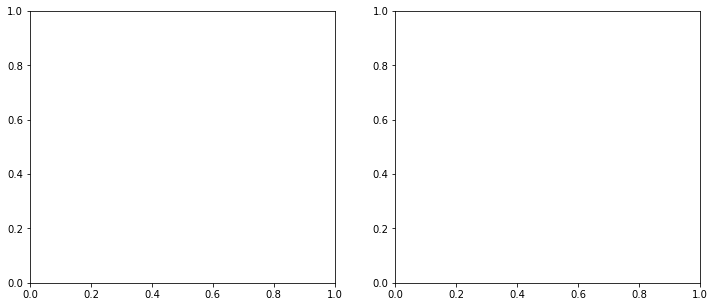

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

by_slope_nobias.plot.scatter(x='slope', y='mae', c='C1', ax=ax1, s=6)
by_slope.plot.scatter(x='slope', y='mae', c='C0', ax=ax1, s=6)
by_yearly_obs_nobias.plot.scatter(x='n', y='mae', c='C1', ax=ax2, s=6)
by_yearly_obs.plot.scatter(x='n', y='mae', c='C0', ax=ax2, s=6)
by_slope.plot.scatter(x='slope', y='bias', c='dimgrey', ax=ax1, s=6)
by_yearly_obs.plot.scatter(x='n', y='bias', c='dimgrey', ax=ax2, s=6)

# Add trendline and restrict extent
z = lowess(by_slope['mae'], by_slope['slope'])
ax1.plot(z[:, 0], z[:, 1], '--', color = 'C0', linewidth = 1.3, zorder=3);
z = lowess(by_slope_nobias['mae'], by_slope_nobias['slope'])
ax1.plot(z[:, 0], z[:, 1], '--', color = 'C1', linewidth = 1.3);
z = lowess(by_yearly_obs['mae'], by_yearly_obs['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'C0', linewidth = 1.3, zorder=3);
z = lowess(by_yearly_obs_nobias['mae'], by_yearly_obs_nobias['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'C1', linewidth = 1.3);
z = lowess(by_slope['bias'], by_slope['slope'])
ax1.plot(z[:, 0], z[:, 1], '--', color = 'dimgrey', linewidth = 1.0, zorder=0);
z = lowess(by_yearly_obs['bias'], by_yearly_obs['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'dimgrey', linewidth = 1.0, zorder=0);

# Set axis limita
ax1.set_xticks(np.arange(0, 0.2, 0.02))
ax1.set_ylabel('Metres (m)')
ax1.set_xlabel('Slope')
ax2.set_xlabel('Survey frequency (observations per year)')
ax2.set_ylim(0, 25)
ax2.yaxis.label.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0)
ax1.legend(['Mean Absolute Error (MAE)', 'Bias-corrected MAE', 'Bias'], frameon=False)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)

# plt.savefig(fname=f'../bishoptaylor_2020/SlopeObs/FigureX_Effectofslopeandobs.png', 
#             bbox_inches='tight',
#             transparent=True,
#             pad_inches=0.05, dpi=300)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: 

Text(0.1817, -7.5, 'Seaward\nbias')

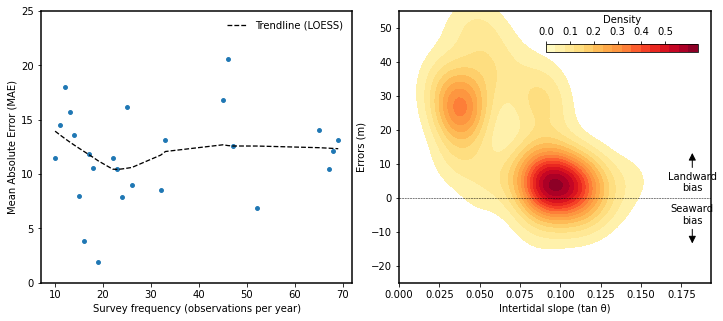

In [191]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))

by_yearly_obs = stats_df.groupby('n').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, False)).drop('n', axis=1).reset_index()
by_yearly_obs.plot.scatter(x='n', y='mae', ax=ax2, s=15)


for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)

by_slope = stats_df[['slope', 'error_m']].dropna(axis=0) 
by_slope['slope'] = by_slope.slope.abs()

sns.kdeplot(ax=ax1,
            data=by_slope['slope'],
            data2=by_slope['error_m'],
            cmap='YlOrRd',
            legend=True, 
            cbar=True,
            shade=True,
            shade_lowest=False,
            levels=16,
            clip=([0, 0.202], [-20, 55]),
            cbar_kws={"use_gridspec":False, 
                      "location":"top",
                      "shrink":0.5, 
                      "anchor":(0.92, 0.0),
                      'label': 'Density',
                      'ticklocation':"left",
                      "ticks": [0, 0.1, 0.2, 0.3, 0.4, 0.5]}
           )

# sns.kdeplot(ax=ax1,
#             data=by_slope['slope'],
#             data2=by_slope['error_m'],
#             colors="black",
#             shade=False,
#             shade_lowest=False,
#             levels=16,
#             clip=([0, 0.202], [-20, 55]),
#             linewidths=0.5
# #             linestyles=":"
#            )

# Add trendline and restrict extent
z = lowess(by_yearly_obs['mae'], by_yearly_obs['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1.3, zorder=3);

ax1.set(ylim=(-25, 55))
# # Set axis limita
# ax1.set_xticks(np.arange(0, 0.2, 0.02))
ax1.set_ylabel('Errors (m)')
ax2.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_xlabel('Intertidal slope (tan θ)')
ax2.set_xlabel('Survey frequency (observations per year)')
ax2.set_ylim(0, 25)
plt.subplots_adjust(wspace=0.15, hspace=0)
ax2.legend(['Trendline (LOESS)'], frameon=False)
ax1.axhline(y=0, linestyle='--', color='black', linewidth = 0.5)


ax1.annotate('Landward\nbias', 
             xytext=(0.1817, 2), 
             xy=(0.1817, 13.8), 
             arrowprops={'arrowstyle': '-|>', 
                         'facecolor': 'black', 
                         'mutation_scale': 15}, 
             ha='center')
ax1.annotate('Seaward\nbias', 
             xytext=(0.1817, -7.5), 
             xy=(0.1817, -14), 
             arrowprops={'arrowstyle': '-|>', 
                         'facecolor': 'black', 
                         'mutation_scale': 15}, 
             ha='center')

# plt.savefig(fname=f'../bishoptaylor_2020/SlopeObs/FigureX_Effectofslopeandobs.png', 
#             bbox_inches='tight',
#             transparent=True,
#             pad_inches=0.05, dpi=300)



#### Temporal plots

In [ ]:
id_var = 'id'

ids_to_keep = ([f'dasilva2021_W_{i}' for i in range(1, 20, 2)] + 
               [f'dasilva2021_W_{i}' for i in range(20, 79, 5)] +
               [f'dasilva2021_E_{i}' for i in range(1, 20, 2)] +
               [f'dasilva2021_E_{i}' for i in range(20, 65, 5)])
# ids_to_keep = None

In [ ]:
# Filter to specific IDs
if ids_to_keep:
    stats_subset = stats_df.loc[stats_df[id_var].isin(ids_to_keep)]
    stats_subset = pd.concat([stats_subset.query("section == 'W'").sort_values('profile', ascending=False),
           stats_subset.query("section == 'E'").sort_values('profile', ascending=True)])
else:
    stats_subset = stats_df
    
# Filter to frequency
high_freq = stats_subset.groupby(id_var).filter(lambda x: len(x) >= 1)
high_freq_stats = high_freq.groupby(id_var).apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))

# Merge data and stats
high_freq_merged = pd.merge(
    left=high_freq,
    right=high_freq_stats,
    how="inner",
    on=id_var)

# Optionally, remove bias
high_freq_merged['deacl_dist'] += high_freq_merged['bias']

# Melt dataframe to long
high_freq_melted = pd.melt(high_freq_merged, #.query('corr > 0.8'), 
                    id_vars=[id_var, 'year'], 
                    value_vars=['val_dist', 'deacl_dist'], 
                    value_name='distance')

# Optionally, standardise distance to min = 0
# high_freq_melted['distance'] = high_freq_melted.distance - high_freq_melted.groupby(id_var).distance.transform('min')

In [ ]:
# Plot the lines on two facets
g = sns.relplot(
    data=high_freq_melted,
    x="year", y="distance", hue='variable', kind="line",
    col=id_var, col_wrap=5,
    aspect=1.6, height=1.3,
#     facet_kws={'sharey': False, 'sharex': True},
#     facet_kws={'ylim': (0, 75)
              
)

plt.subplots_adjust(hspace=0.25, wspace=0.10)


In [ ]:
g.fig.savefig(f"dasilva2021_comparison.png", dpi=100)

#### Results by profile
ID filtered to multi-year observations

In [ ]:
by_id = stats_df.groupby('id').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist))

In [ ]:
by_id.query("n > 5").astype('float').boxplot(column='mae')

In [ ]:
by_id.query("n > 5")['mae'].astype('float').plot.hist(bins=30)

#### Effect of validation source

In [ ]:
by_source = stats_df.groupby('source').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_source_nobias = stats_df.groupby('source').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

rse_tableformat(by_source, by_source_nobias)


#### Effect of yearly validation observations

In [ ]:
stats_df.n.sum()

In [ ]:
stats_df[stats_df.n > 1].n.sum()

In [ ]:
1 - (stats_df[stats_df.n == 1].n.sum() / stats_df.n.sum())

In [ ]:
stats_df[stats_df.n >= 12].n.sum()

In [ ]:
stats_df[stats_df.n >= 12].n.sum()  / stats_df.n.sum()

In [ ]:
stats_df[stats_df.n >= 12].beach.unique()

In [ ]:
by_yearly_obs = stats_df.groupby('n').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, False)).drop('n', axis=1).reset_index()

In [ ]:

by_yearly_obs = stats_df.groupby('n').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, False)).drop('n', axis=1).reset_index()
by_yearly_obs.plot.scatter(x='n', y='mae')

# Add trendline and restrict extent
z = lowess(by_yearly_obs['mae'], by_yearly_obs['n'])
plt.gca().plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1, );


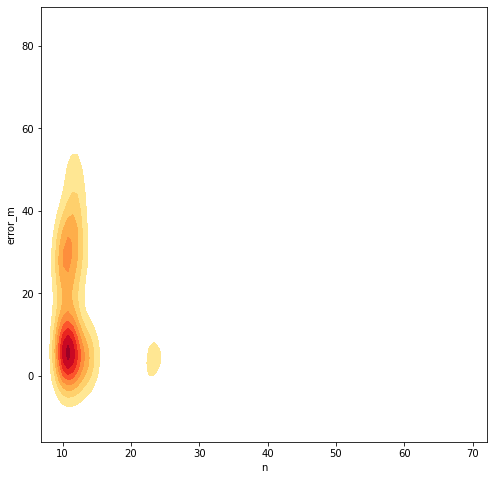

In [182]:
by_slope = stats_df[['n', 'error_m']].dropna(axis=0) 
by_slope['error_m'] = by_slope.error_m.abs()

plt.figure(figsize=(8, 8))
a = sns.kdeplot(ax=plt.gca(),
            data=by_slope['n'],
            data2=by_slope['error_m'],
            cmap='YlOrRd',
            shade=True,
            shade_lowest=False,
#             levels=15,
#             clip=([0, 0.18], [-20, 55]),
           )

# # Add trendline and restrict extent
# z = lowess(by_slope['error_m'], by_slope['slope'])
# plt.gca().plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1, )
# a.set(xlim=(0, 0.18))
# a.set(ylim=(-20, 55))

In [ ]:
by_slope.plot.scatter(x='n', y='error_m')

### Plots

In [ ]:
# # Export evaluation vector
output_name = 'vicdeakin'
export_eval(stats_df, output_name)

In [ ]:
stats_df.section.unique()

In [ ]:
# Print stats and plot scatterplot
stats_subset = stats_df  #.query("section == '10' | section == '9c' | section == '9b' | section == '9a' | section == '8'")  #.query("deacl_dist < 3000")  #.loc[stats_df.id.isin(['bussleton_all_31'])]

def val_plot(df, 
             title='Validation',
             scatter=True, 
             density=True,
             time=True, 
             time_stat='mean',
             time_legend_pos=[0.8, 0.035],
             offset=0,
             extent=(0, 120),
             scatter_kwargs={}, 
             time_kwargs={}):
    
    # Copy data and apply offset
    df = df.copy()
    df['error_m'] += offset
    df['deacl_dist'] += offset

    # Compute stats  
    n, mae, rmse, stdev, corr, bias = deacl_val_stats(
        val_dist=df.val_dist, 
        deacl_dist=df.deacl_dist)    
    offset_str = 'landward offset' if bias > 0 else 'ocean-ward offset'
    print(bias)

    if scatter:
        
        # Plot data as scatterplot
        fig, ax = plt.subplots(figsize=(8, 8))
        df.plot.scatter(x='val_dist',
                        y='deacl_dist',
                        s=15,
                        edgecolors='black',
                        linewidth=0,
#                         xlim=extent,
#                         ylim=extent,
                        ax=ax,
                        **scatter_kwargs)
        
        # Add dashed line
        
        
        ax.plot(
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                color='black',
                linestyle='dashed')
        
        ax.set_xlabel(f'{title} (metres along profile)')
        ax.set_ylabel(f'DEA Coastlines (metres along profile)')
        
        # Add annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Set title
        plt.gca().set_title(f'DEA Coastlines vs {title}', weight='bold')
        
        # Export to file        
        fig.savefig(f"{title}_scatter_offset{offset:.1f}.png", dpi=300)
        
    if density:
        
        fig, ax = plt.subplots(figsize=(8, 8))

        g = sns.kdeplot(ax=ax,
                        data=df.val_dist,
                        data2=df.deacl_dist, 
                        cmap='YlOrRd', 
                        shade=True,
                        bw=3,
                        shade_lowest=False,
                        clip=(extent, extent))

        g.set(xlabel=f'{title} (metres along profile)', 
              ylabel=f'DEA Coastlines (metres along profile)')
        ax.set_title(f'DEA Coastlines vs {title}', weight='bold')

        # Add stats annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Add diagonal line
        plt.gca().plot(np.linspace(*extent), 
                       np.linspace(*extent),
                       color='black',
                       linestyle='dashed')
        
        plt.gca().set_ylim(bottom=extent[0])
        plt.gca().set_xlim(left=extent[0])

        # Export to file
        fig = g.get_figure()
        fig.savefig(f"{title}_heatmap_offset{offset:.1f}.png", dpi=300)
        
    if time:
        
        # Group by beach and apply statistic
        stats_grouped = (df.groupby(['beach', 'year'], as_index=False)
                         .aggregate(time_stat)
                         .rename({'beach': 'id',
                                  'deacl_dist': 'DEA Coastlines',
                                  'val_dist': title}, axis=1)
                         .groupby('id')
                         .filter(lambda x: len(x) > 1))

        # Melt data into long format for faceted plotting
        stats_melted = pd.melt(stats_grouped, 
                               id_vars=['id', 'year'],
                               value_vars=['DEA Coastlines', title],
                               value_name='Distance (m)')

        # Plot facet data
        g = sns.relplot(data=stats_melted,
                        x="year", 
                        y="Distance (m)", 
                        col="id", 
                        hue="variable",
                        height=1.7, 
                        aspect=1.0, 
                        kind="line", 
                        legend='full', 
                        col_wrap=5,
                        **time_kwargs)
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(f'DEA CoastLines vs {title}', 
                       weight='bold', 
                       ha='right')
        
        # Simplify titles
        g.set_titles(row_template='{row_name}', 
                     col_template='{col_name}')

        # Customise legend
        g._legend.texts[0].set_text("")
        g._legend.set_bbox_to_anchor(time_legend_pos)
        
        # Export to file
        g.savefig(f"{title}_time_offset{offset:.1f}.png", dpi=300)
        
    return pd.Series({'Mean Absolute Error': mae, 
                    f'RMSE': rmse,
                    f'Standard deviation': stdev,
                    f'Bias': f'{bias:.1f} m {offset_str}',
                    f'Correlation': corr})

# for i, sub in stats_subset.groupby('smartline'):

#     # Run analysis
#     g = val_plot(df=sub,  # stats_subset,
#                  title=i.replace('/', '-'),
#                  scatter=True, 
#                  density=False,
#                  time=False,
#                  time_stat='median',
#                  time_legend_pos=[0.67, 0.11],
#                  offset=0,
#                  extent=(0, 1000))

# Run analysis
g = val_plot(df=stats_subset,  # stats_subset,
         title='nswbpd_eurobodallabeachessouth',
         scatter=True, 
         density=True,
         time=False,
         time_stat='median',
         time_legend_pos=[0.67, 0.11],
         offset=0,
         extent=(0, 300))

## Extracting data along profiles

In [ ]:
# Import required packages
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from otps import TimePoint
from otps import predict_tide
from datacube.utils.geometry import CRS
from shapely.geometry import box, shape

# Widgets and WMS
from odc.ui import ui_poll, select_on_a_map
from ipyleaflet import (Map, WMSLayer, WidgetControl, FullScreenControl, 
                        DrawControl, basemaps, basemap_to_tiles, TileLayer)
from ipywidgets.widgets import Layout, Button, HTML
from IPython.display import display
from types import SimpleNamespace



def extract_geometry(profile,
                     start,
                     transect_mode='distance'): 
    
    try:

        # Convert geometry to a GeoSeries
        profile = gpd.GeoSeries(profile, 
                                crs='EPSG:4326')
        start = gpd.GeoSeries(start, 
                              crs='EPSG:4326').to_crs('EPSG:3577')

        # Load data from WFS
        xmin, ymin, xmax, ymax = profile.total_bounds
        deacl_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                    f'service=WFS&version=1.1.0&request=GetFeature' \
                    f'&typeName=dea:coastlines&maxFeatures=1000' \
                    f'&bbox={ymin},{xmin},{ymax},{xmax},' \
                    f'urn:ogc:def:crs:EPSG:4326'
        deacl = gpd.read_file(deacl_wfs)
        deacl.crs = 'EPSG:3577'

        # Raise exception if no coastlines are returned
        if len(deacl.index) == 0:
            raise ValueError('No annual coastlines were returned for the '
                             'supplied transect. Please select another area.')

        # Dissolve by year to remove duplicates, then sort by date
        deacl = deacl.dissolve(by='year', as_index=False)
        deacl['year'] = deacl.year.astype(int)
        deacl = deacl.sort_values('year')

        # Extract intersections and determine type
        profile = profile.to_crs('EPSG:3577')
        intersects = deacl.apply(
            lambda x: profile.intersection(x.geometry), axis=1)
        intersects = gpd.GeoSeries(intersects[0]) 

        # Select geometry depending on mode
        intersects_type = (intersects.type == 'Point' if 
                           transect_mode == 'distance' else 
                           intersects.type == 'MultiPoint')

        # Remove annual data according to intersections
        deacl_filtered = deacl.loc[intersects_type]
        drop_years = ', '.join(deacl.year
                               .loc[~intersects_type]
                               .astype(str)
                               .values.tolist())

        # In 'distance' mode, analyse years with one intersection only
        if transect_mode == 'distance':  

            if drop_years:
                print(f'Dropping years due to multiple intersections: {drop_years}\n')            

            # Add start and end coordinate
            deacl_filtered['start'] = start.iloc[0]
            deacl_filtered['end'] = intersects.loc[intersects_type]

        # If any data was returned:
        if len(deacl_filtered.index) > 0:   

            # Compute distance
            deacl_filtered['dist'] = deacl_filtered.apply(
                lambda x: x.start.distance(x.end), axis=1)

            # Extract values
            transect_df = pd.DataFrame(deacl_filtered[['year', 'dist']])
            transect_df['dist'] = transect_df.dist.round(2)

            # Plot data
#             fig, ax = plt.subplots(1, 1, figsize=(5, 8))
#             transect_df.plot(x='dist', y='year', ax=ax, label='DEA Coastlines')
#             ax.set_xlabel(f'{transect_mode.title()} (metres)')

            return transect_df.set_index('year')
    
    except:
        pass
       


In [ ]:
profile_list = []

for val_path in val_paths:
    
    val_df = pd.read_csv(val_path).groupby('id').first()

    # Convert validation start and end locations to linestrings
    from shapely.geometry import box, Point, LineString
    val_geometry = val_df.apply(
        lambda x: LineString([(x.end_x, x.end_y), (x.start_x, x.start_y)]), axis=1)

    # Convert geometries to GeoDataFrame
    val_gdf = gpd.GeoDataFrame(data=val_df,
                               geometry=val_geometry,
                               crs='EPSG:3577').to_crs('EPSG:4326')

    # Get start coord
    val_gdf['start_point'] = val_gdf.apply(
        lambda x: Point(x.geometry.coords[1]), axis=1)

    for i in val_gdf.index:
        print(i)
        profile_df = extract_geometry(val_gdf.loc[i].geometry, val_gdf.loc[i].start_point)
        if profile_df is not None:
            profile_list.append(profile_df.rename({'dist': i}, axis=1))


In [ ]:
pd.concat(profile_list, axis=1).to_csv('fellowes_et_al_2021_profiles_deacoastlines.csv')

## Narrabeen BPD

In [12]:
out = pd.read_csv('/g/data/r78/DEACoastlines/validation/output_data/wrl_narrabeen.csv', parse_dates=['date'])
out = out.set_index('date')
out.head()

,id,beach,section,profile,name,source,slope,start_x,start_y,end_x,end_y,0_dist,0_x,0_y
date,,,,,,,,,,,,,,
1988-01-25,narrabeen_all_pf1,narrabeen,all,pf1,wrl,emery/levelling,-0.092,1.772383e+06,-3.812083e+06,1.772527e+06,-3.812212e+06,103.642857,1.772460e+06,-3.812152e+06
1988-02-23,narrabeen_all_pf1,narrabeen,all,pf1,wrl,emery/levelling,-0.088,1.772383e+06,-3.812083e+06,1.772527e+06,-3.812212e+06,95.500000,1.772454e+06,-3.812147e+06
1988-03-21,narrabeen_all_pf1,narrabeen,all,pf1,wrl,emery/levelling,-0.086,1.772383e+06,-3.812083e+06,1.772527e+06,-3.812212e+06,96.350365,1.772455e+06,-3.812147e+06
1988-04-20,narrabeen_all_pf1,narrabeen,all,pf1,wrl,emery/levelling,-0.122,1.772383e+06,-3.812083e+06,1.772527e+06,-3.812212e+06,102.383721,1.772459e+06,-3.812151e+06
1988-06-11,narrabeen_all_pf1,narrabeen,all,pf1,wrl,emery/levelling,-0.107,1.772383e+06,-3.812083e+06,1.772527e+06,-3.812212e+06,97.734375,1.772456e+06,-3.812148e+06


In [17]:
out.query("id == 'narrabeen_all_pf8'")['0_dist'].min().

25.33333333333333

In [18]:
out.query("id == 'narrabeen_all_pf8'")['0_dist'].max()

105.0

In [24]:
out = pd.read_csv('v1.1.4_wrl_narrabeen.csv')

In [25]:
out.query("id == 'narrabeen_all_pf8'")['deacl_dist'].max() - out.query("id == 'narrabeen_all_pf8'")['deacl_dist'].min()

40.76241265157691

array(['narrabeen_all_pf1', 'narrabeen_all_pf2', 'narrabeen_all_pf4',
       'narrabeen_all_pf6', 'narrabeen_all_pf8'], dtype=object)

In [26]:
id_var = out.id.unique()[-1]
out.loc[out.id == id_var]['0_dist'].plot()

KeyError: '0_dist'

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** March 2021